# Applies Deep Learning to ePodium dataset for prediction of Dyslexia.

#### Import Packages

In [1]:
import mne
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import ipywidgets
import tensorflow as tf

from functions import epodium, epodium_deep_learning, display_helper
from models.dnn import fully_connected_model
from models import transformer

import local_paths

2022-09-13 15:46:10.910896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-13 15:46:10.910932: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Choose which processed data to use

In [2]:
processing_method_widget = ipywidgets.RadioButtons(options=['autoreject', 'ransac'], 
                                                   value='autoreject', 
                                                   description='processing:')
display(processing_method_widget)

RadioButtons(description='processing:', options=('autoreject', 'ransac'), value='autoreject')

<br>

## Preparing data iterator (Sequence) as input to the deep learning models.
https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence

#### Split processed epochs* into train and test sequence.

*In the context of electroencephalography (EEG), *epochs* are EEG segments in which an event occurs. During processing, the epochs are chosen to be 1 second in which the event occurs at 0.2s. In the context of deep learning, *epochs* are iterations over the entire training dataset.

In [3]:
train, test = epodium_deep_learning.split_train_test_datasets(processing_method_widget.value)
train_sequence = epodium_deep_learning.EvokedDataIterator(train, "autoreject_128hz")
test_sequence = epodium_deep_learning.EvokedDataIterator(test, "autoreject_128hz")

Analyzed: 228, bad: 42
186 files have enough epochs for analysis.
The dataset is split up into 138 train and 48 test experiments


#### Visualise data instance

In [4]:
x, y = train_sequence.__getitem__(0)
print(f"The shape of one data instance is {x[0].shape}")

The shape of one data instance is (64, 128)


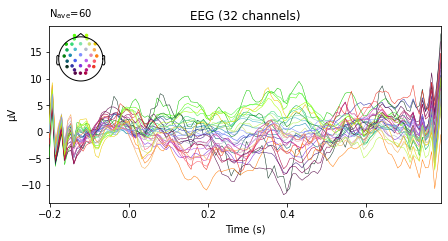

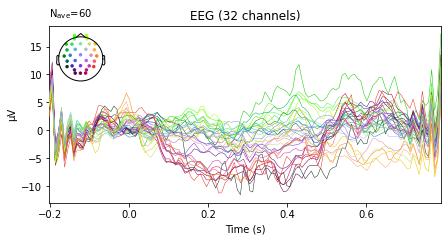

In [5]:
index = 23 # 0 to 63

epodium.plot_array_as_evoked(x[index][:32], frequency = 128)
epodium.plot_array_as_evoked(x[index][32:], frequency = 128)

# label_sex = 'male' if y[index][0] else 'female'
# label_risk = 'risk' if y[index][1] else 'no risk'
# label_event = 'deviant' if y[index][2] else 'standard'

# print (f"{int(y[index][0])}: {label_sex}, \
#          {int(y[index][1])}: {label_risk}, \
#          {int(y[index][2])}: {label_event}")

In [6]:
x[index][:32].shape

(32, 128)

#### Choose Deep Learning model

In [7]:
model_widget = ipywidgets.RadioButtons(options=['DNN', 'transformer', 'encoder_age_128'],
                                       description='Models:',
                                       value='encoder_age_128')
display(model_widget)

RadioButtons(description='Models:', index=2, options=('DNN', 'transformer', 'encoder_age_128'), value='encoder…

#### Load model

In [10]:
# Paths to save model info
base_path = os.path.join(local_paths.models, model_widget.value)

path_history = os.path.join(base_path, "history.npy")
path_model = os.path.join(base_path, "model")
path_testset = os.path.join(base_path, "testset.txt")
path_weights = os.path.join(base_path, "weights.h5")

# Load Model
if(os.path.exists(path_model)):
    print(f"Loading Model: '{model_widget.value}'.")
    
    # Loads the entire model from a folder:
    model = tf.keras.models.load_model(path_model)
    model.load_weights(path_weights)
    # Reads the test-set of the trained model and puts the experiment names into a list:
    testset = open(path_testset, "r").read().split()
    # Loads the training history dictionary:
    history = np.load(path_history, allow_pickle=True).item()
else: print("Model not found")

Loading Model: 'encoder_age_128'.


2022-09-13 15:48:15.200735: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-13 15:48:15.200792: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-13 15:48:15.200822: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (floriscpu): /proc/driver/nvidia/version does not exist
2022-09-13 15:48:15.201134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/fpauwels/.local/lib/python3.8/site-packages/keras/layers/core/lambda_layer.py:303: UserWarning: models.hfaw

<br>

## Analyzing trained models

#### Show Training History

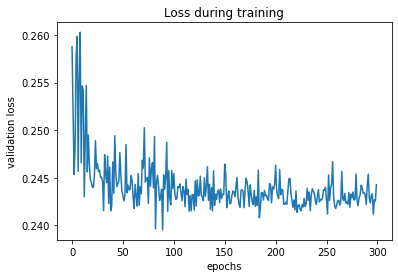

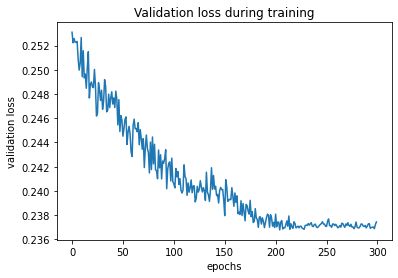

In [11]:
display_helper.show_plot(x = range(len(history['loss'])), y = history['loss'] ,xlabel = "epochs", ylabel = "validation loss", title = "Loss during training")
display_helper.show_plot(x = range(len(history['loss'])), y = history['val_loss'] ,xlabel = "epochs", ylabel = "validation loss", title = "Validation loss during training")

#### Make predictions on test set

In [13]:
# Loop over test_set, analyse each file x amount of time

for testfile in testset: 
    
    
    
    
    test_experiment = epodium_deep_learning.EvokedDataIterator([testfile], path_processed, n_experiments_batch = 8)

    index = 16
    x, y = test_experiment.__getitem__(0)
    epodium.plot_array_as_evoked(x[index])
    
    print(model.predict(x[index]))

#     label_sex = 'male' if y[index][0] else 'female'
#     label_risk = 'risk' if y[index][1] else 'no risk'
#     label_event = 'deviant' if y[index][2] else 'standard'

#     print (f"{int(y[index][0])}: {label_sex}, \
#          {int(y[index][1])}: {label_risk}, \
#          {int(y[index][2])}: {label_event}")
    
    break

    # Load 

NameError: name 'path_processed' is not defined

In [ ]:
len(x)

In [ ]:
## TODO Choose model from all loaded models:

# path_models = glob.glob(os.path.join(local_paths.models, '*' + model_extension))
# models = []
# paths_model_file = []
# paths_model_history = []

# for path_model in path_models:
#     model_temp = os.path.splitext(path_model)[0]    
#     models.append(os.path.basename(model_temp))
#     paths_model_file.append(model_temp + model_extension)
#     paths_model_history.append(model_temp + '_history.npy')

# model = ipywidgets.Select(options=models, description='Models:')
# display(model)